# Cross validation

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division

In [2]:
X = np.array([['a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'i1', 'j1'], 
              ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2', 'i2', 'j2']]).T
y = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
print('X =', X)
print('y =', y)
print()

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, random_state=1, 
                        shuffle=True)
for train_index, test_index in kfold.split(X, y):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X = [['a1' 'a2']
 ['b1' 'b2']
 ['c1' 'c2']
 ['d1' 'd2']
 ['e1' 'e2']
 ['f1' 'f2']
 ['g1' 'g2']
 ['h1' 'h2']
 ['i1' 'i2']
 ['j1' 'j2']]
y = [1 1 1 1 1 0 0 0 0 0]

TRAIN: [0 1 3 4 5 6 8 9] TEST: [2 7]
TRAIN: [0 2 3 4 5 7 8 9] TEST: [1 6]
TRAIN: [0 1 2 3 5 6 7 8] TEST: [4 9]
TRAIN: [1 2 3 4 6 7 8 9] TEST: [0 5]
TRAIN: [0 1 2 4 5 6 7 9] TEST: [3 8]


<a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html">sklearn.model_selection.cross_val_score</a>

In [3]:
%precision 5

df = pd.read_csv('../shelter_animals/shelter_animals_small.csv')
kfold = StratifiedKFold(n_splits=6, random_state=42, 
                        shuffle=True)

training_columns = ['AnimalType', 'AgeuponOutcome', 
                    'Gender_Male', 'Gender_Unknown', 
                    'Sterilization_Neutered', 
                    'Sterilization_Unknown']
X = df[training_columns].values
y = df['OutcomeType'].values


from sklearn.ensemble import RandomForestClassifier
cv_score = []
for train_index, test_index in kfold.split(X, y):
    clf = RandomForestClassifier(random_state=42, 
                                 n_estimators=10)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    cv_score.append(clf.score(X_test, y_test))

print(np.array(cv_score))

# То же самое:

from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=42, 
                             n_estimators=10,
                             n_jobs=1)
cv_score = cross_val_score(clf, X, y, cv=kfold)
print(cv_score)

[0.63159 0.6425  0.64175 0.62132 0.6282  0.63342]
[0.63159 0.6425  0.64175 0.62132 0.6282  0.63342]


Найдем оптимальное количество деревьев для случайного леса по кросс-валидации:

In [4]:
kfold = StratifiedKFold(n_splits=3, random_state=42, 
                        shuffle=True)

cv_scores = []

estimators_counter = range(1, 601, 10)
for n in estimators_counter:
    clf = RandomForestClassifier(random_state=42, 
                                 n_estimators=n,
                                 n_jobs=4)
    cv_score = cross_val_score(clf, X, y, cv=kfold)
    cv_scores.append(cv_score)

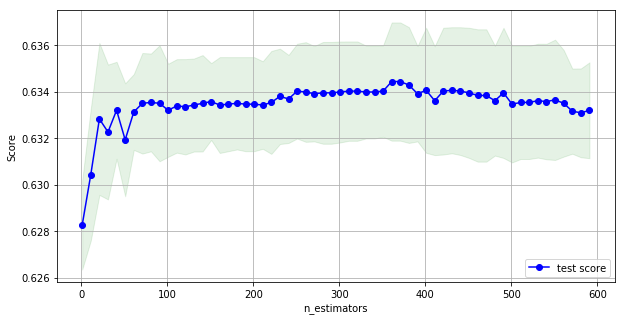

In [9]:
plt.figure(figsize=(10,5))
cv_scores = np.array(cv_scores)
    
scores_mean = np.mean(cv_scores, axis=1)
scores_std = np.std(cv_scores, axis=1)
plt.grid()
plt.fill_between(estimators_counter, 
                 scores_mean - scores_std, 
                 scores_mean + scores_std, 
                 alpha=0.1, color='g')
plt.plot(estimators_counter, scores_mean, 
         'o-', color='b', label='test score')

plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend(loc='lower right');

## Как подобрать мета-параметры алгоритма?

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV">sklearn.model_selection.GridSearchCV</a>

In [10]:
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=6, random_state=42, 
                        shuffle=True)

grid_searcher = GridSearchCV(
    RandomForestClassifier(random_state=42, n_estimators=20), 
                 {'criterion': ['gini', 'entropy'],
                  'max_depth': [1, 3, 5, 7, 10, None]},
                  cv=kfold, n_jobs=3)

grid_searcher.fit(X, y)
print('best score:', grid_searcher.best_score_, grid_searcher.best_params_)

best score: 0.634067866362378 {'criterion': 'gini', 'max_depth': 5}


## Хотите, найти оптимальные параметры быстрее? 

Выход есть и их много! Например: <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">sklearn.model_selection.RandomizedSearchCV</a>

Еще быстрее: http://hyperopt.github.io/hyperopt-sklearn/

<img src="http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg">

## Как выбрать количество фолдов?

In [13]:
%precision 4
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv_scores = []
for n_splits in range(2, 20):
    cv_scores.append([])
    print('n_splits={}'.format(n_splits))
    for i in range(20):
        kfold = StratifiedKFold(n_splits=n_splits, random_state=i, 
                                shuffle=True)
        cv_score = cross_val_score(
            RandomForestClassifier(random_state=40, n_estimators=10),
                df[training_columns], df['OutcomeType'], cv=kfold)
        cv_scores[-1].append(np.mean(cv_score))

n_splits=2
n_splits=3
n_splits=4
n_splits=5
n_splits=6
n_splits=7
n_splits=8
n_splits=9
n_splits=10
n_splits=11
n_splits=12
n_splits=13
n_splits=14
n_splits=15
n_splits=16
n_splits=17
n_splits=18
n_splits=19


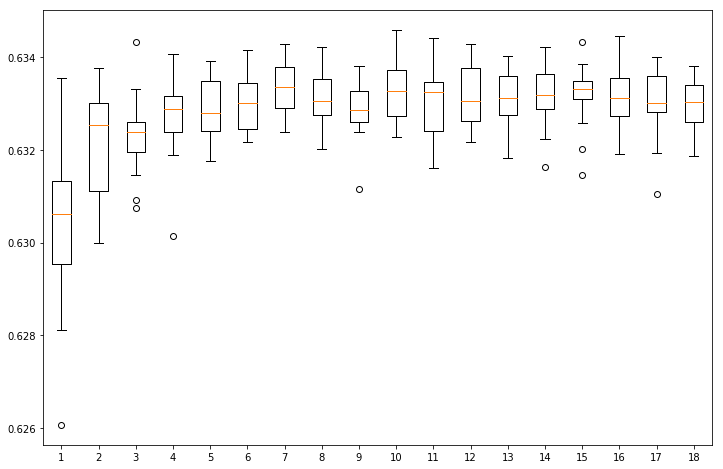

In [14]:
plt.figure(figsize=(12, 8))
plt.boxplot(cv_scores);

Стандартное отклонение среднего для x фолдов при 20 пробах:

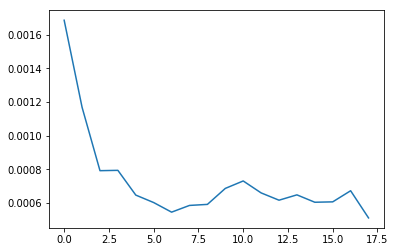

In [15]:
plt.plot([np.std(score) for score in cv_scores]);